In [2]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import seaborn as sns
import quantum_sim as qusi
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# functions for trotter
def get_Hamiltonian(N,J,U,h_list):
    assert N==len(h_list)
    H = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in range(N-1)]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in range(N-1)]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in range(N-1)]
                  +[qusi.Pz(h_list[i],i) for i in range(N)])
    return H

#Hamiltonian for Trotter:
"""
EvenBond:   ┌────┐      OddBond:               SingleGate:   ┌────┐
    q0   ---│    │------        -------------             ---│    │----
            │    │                                           └────┘
            │    │                 ┌────┐                    ┌────┐
    q1   ---│    │------        ---│    │----             ---│    │----
            └────┘                 │    │                    └────┘
            ┌────┐                 │    │                    ┌────┐
    q2   ---│    │------        ---│    │----             ---│    │----
            │    │                 └────┘                    └────┘
            │    │                                           ┌────┐
    q3   ---│    │------        -------------             ---│    │----
            └────┘                                           └────┘
"""
def get_trotter_Hamiltonian(N,J,U,h_list):
    assert N==len(h_list)
    evens = []
    odds = []
    for i in range(N-1):
        if i%2==0:
            evens.append(i)
        else:
            odds.append(i)
    # The even bond hamiltonian
    H0 = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in evens]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in evens]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in evens])
    # The odd bond hamiltonian
    H1 = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in odds]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in odds]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in odds])
    # The single gates
    H2 = qusi.SumOp([qusi.Pz(h_list[i],i) for i in range(N)])
    return [H0,H1,H2]

def exact_diag(H,T,t_step):
    return linalg.expm((0-1j)*T/t_step*H)

def basic_trotter(H_list,T,t_step,N):
    eH_list = []
    for H in H_list:
        eH_list.append(exact_diag(H.as_sparse_matrix(N),T,t_step))
    return eH_list[2]@eH_list[1]@eH_list[0]

def symmetric_trotter(H_list,T,t_step,N):
    eH_list = [linalg.expm((0-1j)*T/t_step*H_list[0].as_sparse_matrix(N)),linalg.expm((0-.5j)*T/t_step*H_list[1].as_sparse_matrix(N)),linalg.expm((0-.5j)*T/t_step*H_list[2].as_sparse_matrix(N))]
    return eH_list[2]@eH_list[1]@eH_list[0]@eH_list[1]@eH_list[2]

def get_initial_state(N,s=0):
    if s==0:
        l0 = [1 for i in range(int(N/2))]
        l1 = [0 for i in range(int(N-N/2))]
        return qusi.qstate(l0+l1)
    else:
        return qusi.qstate([i%2 for i in range(N)])

In [4]:
N = 6
J = 1
U = 0
h = 0
#h = 1.5
h_list = [i*h for i in range(N)]

T = 2.5
t_step = 250

In [5]:
ed_dict = {}
H= get_Hamiltonian(N,J,U,h_list)
eH = exact_diag(H.as_sparse_matrix(N),T,t_step)
for s in range(2):
    q = get_initial_state(N,s)
    fq_result = np.zeros(t_step)
    for i in range(t_step):
        fq_result[i] = q.get_fq()
        q.time_evolution(eH)
    if s==0:
        ed_dict['wall_state'] = fq_result
    else:
        ed_dict['neel_state'] = fq_result
ed_df = pd.DataFrame(ed_dict)
#ed_df.to_csv('data/ed_fn.csv', index=False)

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_14920\610146724.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  fq_result[i] = q.get_fq()


In [6]:
trotter_dict = {}
H_list = get_trotter_Hamiltonian(N,J,U,h_list)
eH = symmetric_trotter(H_list,T,t_step,N)
for s in range(2):
    q = get_initial_state(N,s)
    fq_result = np.zeros(t_step)
    for i in range(t_step):
        fq_result[i] = q.get_fq()
        q.time_evolution(eH)
    if s==0:
        trotter_dict['wall_state'] = fq_result
    else:
        trotter_dict['neel_state'] = fq_result
trotter_df = pd.DataFrame(ed_dict)
#trotter_df.to_csv('data/trotter_fn.csv', index=False)

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_14920\2311415404.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  fq_result[i] = q.get_fq()


In [7]:
qiskit_df = pd.read_csv('data/qiskit_fn.csv')
ticks = [i*T/t_step for i in range(t_step)]
color_list = ['#66FFFF','#3FEB76','#EB613F']

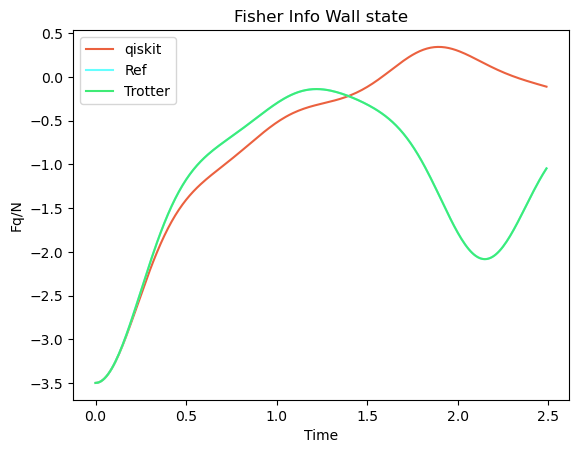

In [8]:
plt.plot(ticks, qiskit_df.wall_state,color = color_list[2], label='qiskit')
plt.plot(ticks, ed_dict['wall_state'],color = color_list[0],label='Ref')
plt.plot(ticks, trotter_dict['wall_state'],color = color_list[1],label='Trotter')
plt.title('Fisher Info Wall state')
plt.xlabel('Time')
plt.ylabel('Fq/N')
plt.legend()
plt.show()

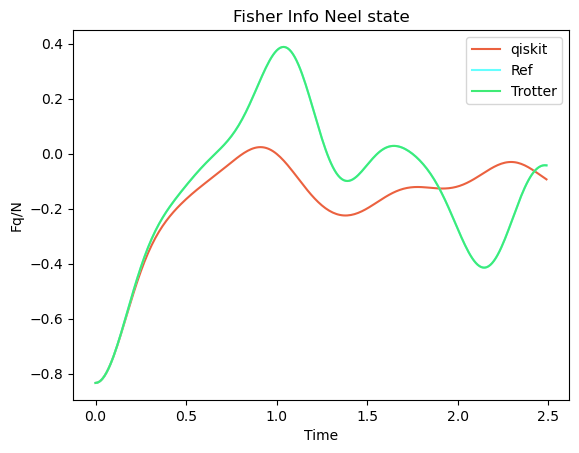

In [9]:
plt.plot(ticks, qiskit_df.neel_state,color = color_list[2], label='qiskit')
plt.plot(ticks, ed_dict['neel_state'],color = color_list[0],label='Ref')
plt.plot(ticks, trotter_dict['neel_state'],color = color_list[1],label='Trotter')
plt.title('Fisher Info Neel state')
plt.xlabel('Time')
plt.ylabel('Fq/N')
plt.legend()
plt.show()